The only purpose of this notebook is to generate a submission.

In [1]:
LOCAL = True
data_fpath = '../data/raw/' if LOCAL else '/kaggle/input/protein-localization/'
data_eng_fpath = '../data/intermediate/' if LOCAL else '../input/data-engineering/'
out_fpath = '../data/intermediate/' if LOCAL else ''
selected_feats_fpath = '../data/intermediate/' if LOCAL else '../input/lightgbm-feature-selection/'

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import data_tools

In [3]:
from datetime import datetime
import pickle

import lightgbm as lgb
import pandas as pd
import numpy as np

SEED = 42

In [4]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


from imblearn.over_sampling import RandomOverSampler, SMOTENC

In [5]:
# Use the accuracy metric
def accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'acc.', accuracy_score(y_true, preds), True

def balanced_accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'bal. acc.', balanced_accuracy_score(y_true, preds), True

def f1_weighted(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='weighted'), True

def f1_macro(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='macro'), True

## Load Training DataFrame

In [6]:
X = pd.read_pickle(f"{data_eng_fpath}X.pkl")
y = pd.read_pickle(f"{data_eng_fpath}y.pkl")
X.shape, y.shape

((862, 476), (862,))

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Columns: 476 entries, 1 to interaction_max3
dtypes: category(447), float64(9), int64(20)
memory usage: 585.4 KB


## Load Competition Data
* Note that data engineering pipeline drops labels, so we'll need thos

In [8]:
testdf = pd.read_csv(f"{data_fpath}test.csv", header=None)

## Feature Selection
* See feature selection notebook

In [9]:
with open(f'{selected_feats_fpath}important_feats.pkl', 'rb') as handle:
    important_feats = pickle.load(handle)

In [10]:
X = X[important_feats]

## Split Data
* Because some classes literally have one training instance, first I duplicate those values so they can appear in test data (best we can do tbh)
* Then I upsample training data again, because we need this to satisfy SMOTE conditions
* Afterwards, I split to train/test, and then use SMOTE/ADASYN on minority classes

In [11]:
ros = RandomOverSampler(sampling_strategy={i : 2 for i in range(12, 15)}, random_state=SEED)
X_upsampled, y_upsampled = ros.fit_resample(X, y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_upsampled, y_upsampled, test_size=0.2, stratify=y_upsampled, random_state=SEED)

# If you use a validation set, you'll need to change the SMOTE cells

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)
# X_train.shape, X_val.shape, X_test.shape
X_train.shape, X_test.shape

((691, 137), (173, 137))

In [13]:
categoricals = X_train.select_dtypes(include=['category']).columns
categoricals_by_idx = [X_train.columns.get_loc(c) for c in categoricals]

In [14]:
# Can't have NaNs for SMOTE, luckily not too many to impute (see data_engineering notebook)
# Impute numerical by average of class
# For categorical, give a new class called "missing"
X_train.isna().any().any()

False

In [15]:
train_class_count = y_train.value_counts().to_dict()

In [16]:
# This specifies how much I want to amplify the minority classes
# Don't want to bias the model too much so I'll have to be careful here not to amplify too much
N_NBRS_SMOTE = 4  # SMOTE kNN condition

strat_1 = {i : round(train_class_count[i]*1.4) for i in range(1, 4)}  # Classes 1 to 3
strat_2 = {i : round(train_class_count[i]*1.8) for i in range(4, 9)}  # Classes 4 to 8
strat_3 = {i : round(train_class_count[i]*1) for i in range(9, 15)}  # Classes 9 to 14
sampling_strategy = {**strat_1, **strat_2, **strat_3}

In [17]:
# Use SMOTE
sm = SMOTENC(categorical_features=categoricals_by_idx,
             sampling_strategy= sampling_strategy,
             random_state=SEED,
             k_neighbors=N_NBRS_SMOTE - 1,
             n_jobs=-1
            )
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [18]:
y_resampled.value_counts()

0     293
1     216
2      77
3      64
4      61
5      61
6      50
7      25
8      25
9       8
10      3
11      2
12      2
13      2
14      2
Name: 2960, dtype: int64

### LightGBM

In [19]:
N_ESTIMATORS = 1000  # default is 100
hyper_params = {
    'boosting_type': 'gbdt',
    'random_state' : SEED,
    'objective' : 'multiclass',
#     'zero_as_missing' : True,
    'metric' : 'None',

    'reg_alpha': 0,
    'reg_lambda' : 0,
    'num_leaves': 400,
    'max_depth' : 8,
    'colsample_bytree' : 0.8,
    'subsample' : 0.9,
    'min_child_samples': 15,

    # Training Parameters
    'learning_rate' : 0.005,
    'n_estimators': N_ESTIMATORS,
#     'first_metric_only' : True,
}
# model = lgb.LGBMClassifier(**hyper_params)
model = lgb.LGBMClassifier()
model.set_params(**hyper_params)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=8,
               metric='None', min_child_samples=15, n_estimators=1000,
               num_leaves=400, objective='multiclass', random_state=42,
               reg_alpha=0, reg_lambda=0, subsample=0.9)

In [20]:
fit_params={
    "early_stopping_rounds": 200, 
    "eval_metric" : [
        accuracy,
#         'logloss',
        f1_macro,
#         balanced_accuracy,
    ],
    "eval_set" : [
        (X_resampled, y_resampled),
#         (X_val, y_val),
        (X_test, y_test),
    ],
    'eval_names': ['train', 'validation'],
    'verbose': N_ESTIMATORS // 10,
    
}
model.fit(X_resampled, y_resampled, **fit_params)


Training until validation scores don't improve for 200 rounds
[100]	train's acc.: 0.727273	train's f1: 0.528404	validation's acc.: 0.635838	validation's f1: 0.289261
[200]	train's acc.: 0.85073	train's f1: 0.75753	validation's acc.: 0.67052	validation's f1: 0.386083
[300]	train's acc.: 0.89899	train's f1: 0.845773	validation's acc.: 0.676301	validation's f1: 0.4564
[400]	train's acc.: 0.916947	train's f1: 0.871143	validation's acc.: 0.687861	validation's f1: 0.46414
[500]	train's acc.: 0.929293	train's f1: 0.878085	validation's acc.: 0.705202	validation's f1: 0.50226
[600]	train's acc.: 0.941639	train's f1: 0.888016	validation's acc.: 0.699422	validation's f1: 0.497057
Early stopping, best iteration is:
[463]	train's acc.: 0.921437	train's f1: 0.87429	validation's acc.: 0.705202	validation's f1: 0.502207


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=8,
               metric='None', min_child_samples=15, n_estimators=1000,
               num_leaves=400, objective='multiclass', random_state=42,
               reg_alpha=0, reg_lambda=0, subsample=0.9)

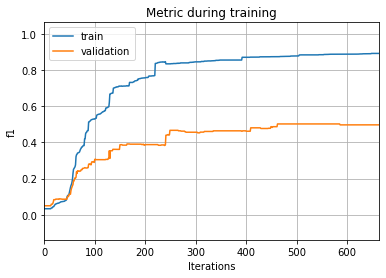

In [21]:
lgb.plot_metric(model);

In [22]:
y_pred = pd.Series(model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        73
           1       0.49      0.55      0.52        38
           2       0.76      0.93      0.84        14
           3       0.62      0.67      0.64        12
           4       0.14      0.11      0.12         9
           5       0.80      0.44      0.57         9
           6       0.67      0.29      0.40         7
           7       0.67      0.50      0.57         4
           8       1.00      0.67      0.80         3
           9       1.00      0.50      0.67         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1

    accuracy                           0.71       173
   macro avg       0.58      0.47      0.50       173
weighted avg       0.70      0.71      0.69       173



# Full model fit

In [23]:
class_count = y.value_counts().to_dict()
class_count  # Class count of full dataset

{0: 366,
 1: 192,
 2: 69,
 3: 58,
 4: 43,
 5: 43,
 6: 35,
 7: 18,
 8: 17,
 9: 10,
 10: 4,
 11: 3,
 12: 2,
 13: 1,
 14: 1}

## Resample Full Training Set

In [24]:
strat_1 = {i : round(class_count[i]*1.4) for i in range(1, 4)}  # Classes 1 to 3
strat_2 = {i : round(class_count[i]*1.8) for i in range(4, 9)}  # Classes 4 to 8
strat_3 = {i : max(round(class_count[i]*2), N_NBRS_SMOTE) for i in range(9, 15)}  # Classes 10 to 14
sampling_strategy = {**strat_1, **strat_2, **strat_3}

In [25]:
# ** Only run this cell if you need to oversample for SMOTE (i.e. number in class < N_NBRS_SMOTE)
ros = RandomOverSampler(sampling_strategy={i : N_NBRS_SMOTE for i in range(10, 15)}, random_state=SEED)
X, y = ros.fit_resample(X, y)

In [26]:
# Use SMOTE
sm = SMOTENC(categorical_features=categoricals_by_idx,
             sampling_strategy= sampling_strategy,
             random_state=SEED,
             k_neighbors=N_NBRS_SMOTE - 1,
             n_jobs=-1
            )
X_full_resampled, y_full_resampled = sm.fit_resample(X, y)

In [27]:
y_full_resampled.value_counts()

0     366
1     269
2      97
3      81
4      77
5      77
6      63
7      32
8      31
9      20
10      8
11      6
12      4
13      4
14      4
Name: 2960, dtype: int64

## Fit model on full dataset

In [28]:
hyper_params['n_estimators'] = 450
hyper_params['learning_rate'] = 0.005

full_model = lgb.LGBMClassifier()
full_model.set_params(**hyper_params)
full_fit_params={
    "early_stopping_rounds": 100, 
    "eval_metric" : [
        f1_macro,
        balanced_accuracy,
        accuracy
    ],
    "eval_set" : [(X, y)],
    'eval_names': ['train'],
    'verbose': hyper_params['n_estimators'] // 10,
    
}
full_model.fit(X_full_resampled, y_full_resampled, **full_fit_params)

Training until validation scores don't improve for 100 rounds
[45]	train's f1: 0.130773	train's bal. acc.: 0.124578	train's acc.: 0.548794
[90]	train's f1: 0.478248	train's bal. acc.: 0.405996	train's acc.: 0.726751
[135]	train's f1: 0.705115	train's bal. acc.: 0.636415	train's acc.: 0.792193
[180]	train's f1: 0.754746	train's bal. acc.: 0.708673	train's acc.: 0.817451
[225]	train's f1: 0.788293	train's bal. acc.: 0.756123	train's acc.: 0.84845
[270]	train's f1: 0.799711	train's bal. acc.: 0.772214	train's acc.: 0.864524
[315]	train's f1: 0.810298	train's bal. acc.: 0.787845	train's acc.: 0.87256
[360]	train's f1: 0.8258	train's bal. acc.: 0.804467	train's acc.: 0.888634
[405]	train's f1: 0.831577	train's bal. acc.: 0.812146	train's acc.: 0.89667
[450]	train's f1: 0.84091	train's bal. acc.: 0.820837	train's acc.: 0.911596
Did not meet early stopping. Best iteration is:
[449]	train's f1: 0.84091	train's bal. acc.: 0.820837	train's acc.: 0.911596


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=8,
               metric='None', min_child_samples=15, n_estimators=450,
               num_leaves=400, objective='multiclass', random_state=42,
               reg_alpha=0, reg_lambda=0, subsample=0.9)

# Competition Data

### Create Submission

In [29]:
X_kaggle = pd.read_pickle(f"{data_eng_fpath}X_kaggle.pkl")
X_kaggle.shape

(381, 476)

In [30]:
y_kaggle = pd.Series(full_model.predict(X_kaggle[important_feats]))
pd.concat((y_kaggle.value_counts().sort_index(), y_kaggle.value_counts().sort_index() / len(y_kaggle)), axis=1)

,0,1
0,174,0.456693
1,129,0.338583
2,12,0.031496
3,22,0.057743
4,7,0.018373
5,16,0.041995
6,9,0.023622
7,6,0.015748
8,4,0.010499
9,1,0.002625


In [31]:
# Compare with class distribution of training set
pd.concat((y.value_counts().sort_index(), y.value_counts().sort_index() / len(y)), axis=1)

,2960,2960
0,366,0.420207
1,192,0.220436
2,69,0.079219
3,58,0.066590
4,43,0.049369
5,43,0.049369
6,35,0.040184
7,18,0.020666
8,17,0.019518
9,10,0.011481


In [32]:
# Now create the kaggle submission file
submission = pd.concat((testdf[0], y_kaggle), axis=1)
submission.columns = ['Key', 'Label']
submission = submission.sort_values('Key').reset_index(drop=True)
submission.head()

,Key,Label
0,P234062,2
1,P234081,1
2,P234086,1
3,P234087,0
4,P234094,0


In [33]:
assert set(submission['Key']) == set(testdf[0])

In [34]:
timestamp = datetime.today().strftime('%Y_%m_%d-%H.%M')
submission_fname = f"submission-{timestamp}.csv"
submission.to_csv(submission_fname, index=False, header=True)
submission_fname

'submission-2021_04_01-17.53.csv'